# Transfer learning

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

100% 1.06G/1.06G [00:09<00:00, 119MB/s]
100% 1.06G/1.06G [00:09<00:00, 127MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16

In [5]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(150,150,3)
)

58889256/58889256 [==============================] - 0s 0us/step


In [6]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [7]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
conv_base.trainable = False

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [11]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [12]:
# Normalize
def process(image,label):
    image = tensorflow.cast(image/255. ,tensorflow.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [13]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [14]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 [==============================] - 62s 88ms/step - loss: 0.2678 - accuracy: 0.8850 - val_loss: 0.2019 - val_accuracy: 0.9136
Epoch 2/10
625/625 [==============================] - 67s 107ms/step - loss: 0.1970 - accuracy: 0.9160 - val_loss: 0.2149 - val_accuracy: 0.9122
Epoch 3/10
625/625 [==============================] - 60s 96ms/step - loss: 0.1520 - accuracy: 0.9383 - val_loss: 0.2070 - val_accuracy: 0.9138
Epoch 4/10
625/625 [==============================] - 60s 96ms/step - loss: 0.1257 - accuracy: 0.9495 - val_loss: 0.2251 - val_accuracy: 0.9078
Epoch 5/10
625/625 [==============================] - 60s 96ms/step - loss: 0.1064 - accuracy: 0.9572 - val_loss: 0.4374 - val_accuracy: 0.8576
Epoch 6/10
625/625 [==============================] - 59s 93ms/step - loss: 0.0885 - accuracy: 0.9643 - val_loss: 0.2478 - val_accuracy: 0.9092
Epoch 7/10
625/625 [==============================] - 68s 108ms/step - loss: 0.0639 - accuracy: 0.9750 - val_loss: 0.3479 - val_accurac

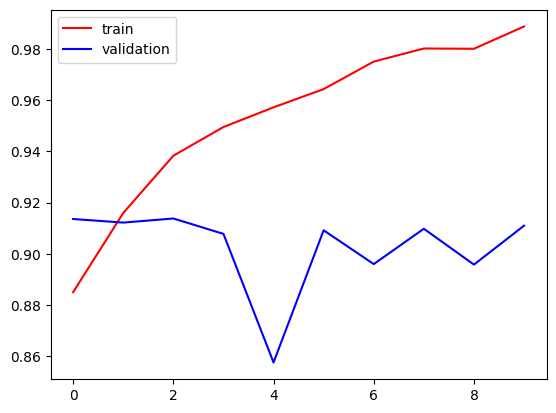

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

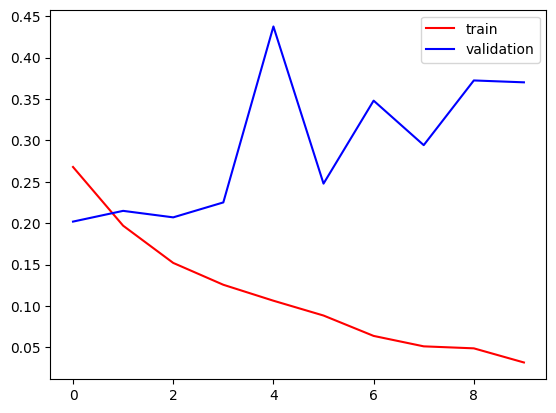

In [16]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

### To reduce overfitting we use data augmentation

In [17]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [18]:
batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/train',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        '/content/test',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [19]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [20]:
history = model.fit_generator(
        train_generator,
        epochs=10,
        validation_data=validation_generator)

<ipython-input-20-b2b64d53260b>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
625/625 [==============================] - 171s 272ms/step - loss: 0.2106 - accuracy: 0.9144 - val_loss: 0.2549 - val_accuracy: 0.9046
Epoch 2/10
625/625 [==============================] - 166s 265ms/step - loss: 0.1797 - accuracy: 0.9261 - val_loss: 0.2312 - val_accuracy: 0.9084
Epoch 3/10
625/625 [==============================] - 165s 263ms/step - loss: 0.1674 - accuracy: 0.9327 - val_loss: 0.2089 - val_accuracy: 0.9166
Epoch 4/10
625/625 [==============================] - 173s 277ms/step - loss: 0.1548 - accuracy: 0.9346 - val_loss: 0.2188 - val_accuracy: 0.9190
Epoch 5/10
625/625 [==============================] - 175s 281ms/step - loss: 0.1481 - accuracy: 0.9391 - val_loss: 0.2576 - val_accuracy: 0.9046
Epoch 6/10
625/625 [==============================] - 175s 281ms/step - loss: 0.1429 - accuracy: 0.9422 - val_loss: 0.2186 - val_accuracy: 0.9202
Epoch 7/10
625/625 [==============================] - 177s 283ms/step - loss: 0.1381 - accuracy: 0.9443 - val_loss: 0.2120 -

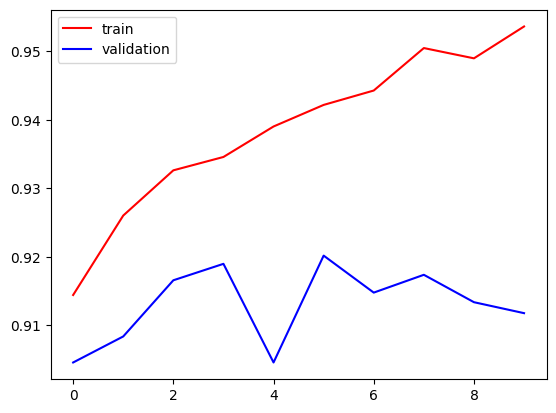

In [22]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

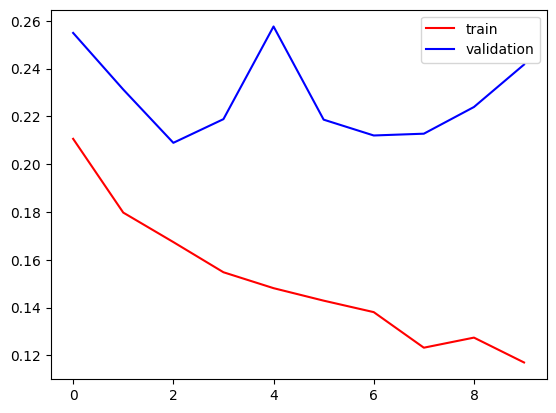

In [23]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [24]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
